### asdf


In [1]:
import os, glob, warnings, re, shutil
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore


In [2]:

def pupil_isc(data, pairwise=True, summary_statistic=np.mean, verbose=True):
    """Intersubject correlation
    For each voxel or ROI, compute the Pearson correlation between each
    subject's response time series and other subjects' response time series.
    If pairwise is False (default), use the leave-one-out approach, where
    correlation is computed between each subject and the average of the other
    subjects. If pairwise is True, compute correlations between all pairs of
    subjects. If summary_statistic is None, return N ISC values for N subjects
    (leave-one-out) or N(N-1)/2 ISC values for each pair of N subjects,
    corresponding to the upper triangle of the pairwise correlation matrix
    (see scipy.spatial.distance.squareform). Alternatively, supply either
    np.mean or np.median to compute summary statistic of ISCs (Fisher Z will
    be applied and inverted if using mean). Input data should be a list 
    where each item is a time-points by voxels ndarray for a given subject.
    Multiple input ndarrays must be the same shape. If a single ndarray is
    supplied, the last dimension is assumed to correspond to subjects. If 
    only two subjects are supplied, simply compute Pearson correlation
    (precludes averaging in leave-one-out approach, and does not apply
    summary statistic.) Output is an ndarray where the first dimension is
    the number of subjects or pairs and the second dimension is the number
    of voxels (or ROIs).
        
    The implementation is based on the following publication:
    
    .. [Hasson2004] "Intersubject synchronization of cortical activity 
    during natural vision.", U. Hasson, Y. Nir, I. Levy, G. Fuhrmann,
    R. Malach, 2004, Science, 303, 1634-1640.
    Parameters
    ----------
    data : list or ndarray
        fMRI data for which to compute ISC
        
    pairwise : bool, default: False
        Whether to use pairwise (True) or leave-one-out (False) approach
        
    summary_statistic : None
        Return all ISCs or collapse using np.mean or np.median
    Returns
    -------
    iscs : subjects or pairs by voxels ndarray
        ISC for each subject or pair (or summary statistic) per voxel
    """
    
    # Convert list input to 3d and check shapes
    if type(data) == list:
        data_shape = data[0].shape
        for i, d in enumerate(data):
            if d.shape != data_shape:
                raise ValueError("All ndarrays in input list "
                                 "must be the same shape!")
            if d.ndim == 1:
                data[i] = d[:, np.newaxis]
        data = np.dstack(data)

    # Convert input ndarray to 3d and check shape
    elif type(data) == np.ndarray:
        if data.ndim == 2:
            data = data[:, np.newaxis, :]            
        elif data.ndim == 3:
            pass
        else:
            raise ValueError("Input ndarray should have 2 "
                             f"or 3 dimensions (got {data.ndim})!")

    # Infer subjects, TRs, voxels and print for user to check
    n_subjects = data.shape[2]
    n_TRs = data.shape[0]
    n_voxels = data.shape[1]
    if verbose:
        print(f"Assuming {n_subjects} subjects with {n_TRs} time points "
              f"and {n_voxels} voxel(s) or ROI(s).")
    
    # Loop over each voxel or ROI
    voxel_iscs = []
    for v in np.arange(n_voxels):
        voxel_data = data[:, v, :].T
        if n_subjects == 2:
            iscs = pearsonr(voxel_data[0, :], voxel_data[1, :])[0]
            summary_statistic = None
            if verbose:
                print("Only two subjects! Simply computing Pearson correlation.")
        elif pairwise:
            iscs = squareform(np.corrcoef(voxel_data), checks=False)
        elif not pairwise:
            iscs = np.array([pearsonr(subject,
                                      np.mean(np.delete(voxel_data,
                                                        s, axis=0),
                                              axis=0))[0]
                    for s, subject in enumerate(voxel_data)])
        voxel_iscs.append(iscs)
    iscs = np.column_stack(voxel_iscs)
    
    # Summarize results (if requested)
    if summary_statistic == np.nanmean:
        iscs = np.tanh(np.nanmean(np.arctanh(iscs), axis=0))[np.newaxis, :]
    elif summary_statistic == np.mean:
        iscs = np.tanh(np.mean(np.arctanh(iscs), axis=0))[np.newaxis, :]
    elif summary_statistic == np.median:    
        iscs = summary_statistic(iscs, axis=0)[np.newaxis, :]
    elif not summary_statistic:
        pass
    else:
        raise ValueError("Unrecognized summary_statistic! Use None, np.median, or np.mean.")
    return iscs




In [3]:
# prepare spots
spot_list = ['commercial_aribnb_30s', 'commercial_att_30s', 'commercial_carscom_30s','commercial_cookies_30s',
             'commercial_dominos_30s', 'commercial_doritos_30s','commercial_expedia_30s','commercial_google_pixel_30s',
             'commercial_hr_block_30s','commercial_jersey_mikes_30s','commercial_lego_30s','commercial_meta_quest_2_30s',
             'commercial_milk_30s','commercial_progressive_30s','commercial_publix_30s','commercial_puma_30s',
             'commercial_starbucks_30s','commercial_under_armour_30s',
             'health_alcohol_30s','health_alzheimers_30s','health_covid_vaccine_30s','health_diet_30s',
             'health_drunk_driving_30s','health_fitness_30s','health_kidney_30s','health_mantherapy_30s',
             'health_prediabetes_30s','health_stroke_30s','health_vaping_30s','health_weight_30s']

n_spots = len(spot_list)

spot_list.sort()
print(len(spot_list))
print(spot_list[:3])

# prepare subject list
sub_folders = glob.glob("../data/00_raw_data/sub*")
sub_folders.sort()
subject_list = []
for f in sub_folders:
    subject_list.append(f[-6:])

n_subjects = len(subject_list)
print(n_subjects)
print(subject_list[:3])

condition_list = ['100', '50nd', '50wd']
n_conditions = len(condition_list)

30
['commercial_aribnb_30s', 'commercial_att_30s', 'commercial_carscom_30s']
59
['sub001', 'sub002', 'sub003']


In [4]:
for i in range(3):
    print(i)

0
1
2


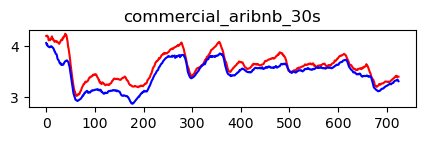

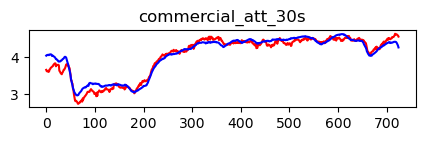

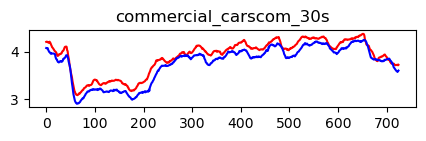

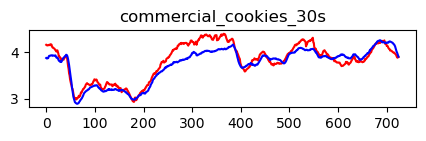

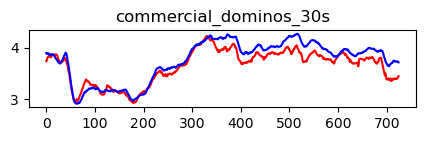

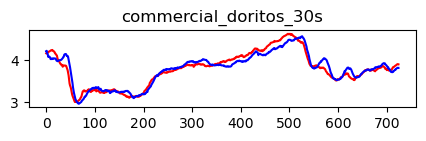

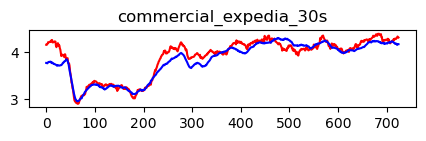

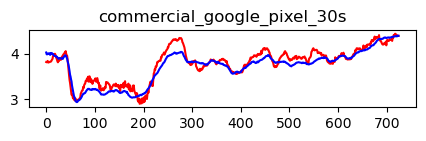

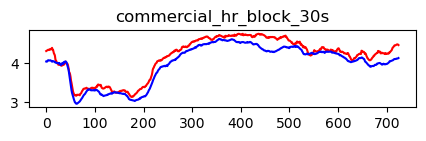

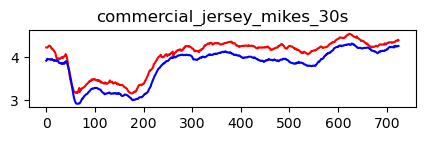

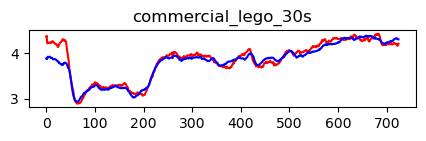

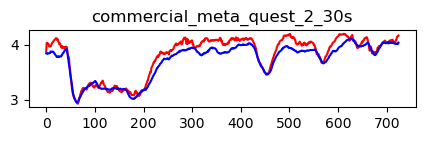

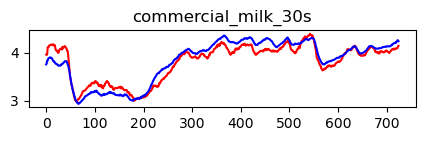

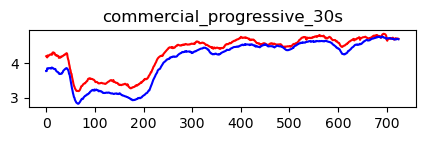

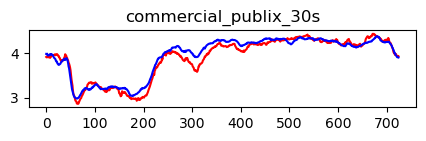

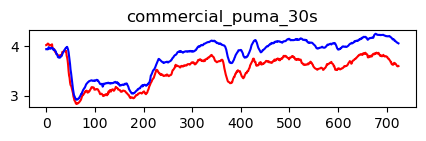

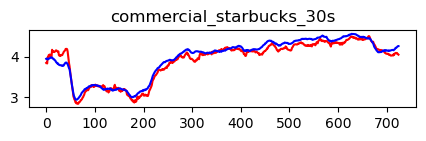

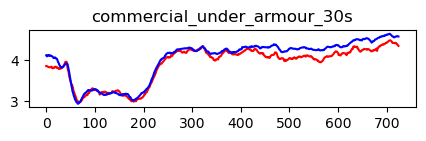

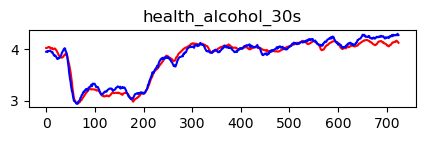

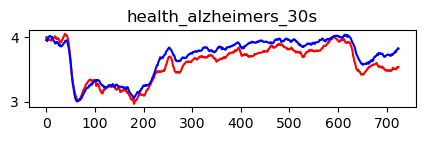

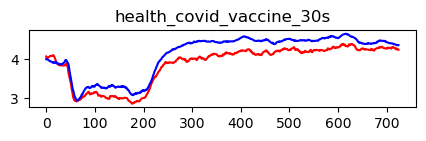

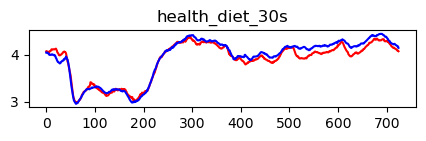

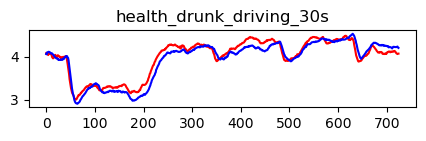

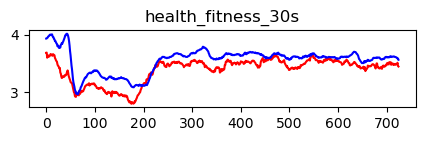

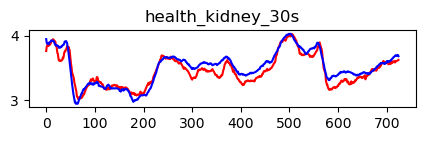

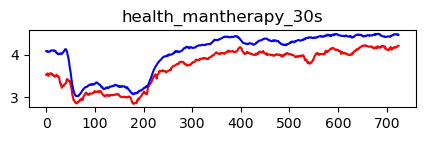

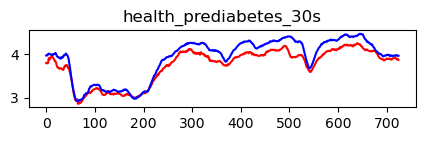

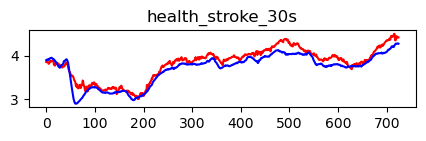

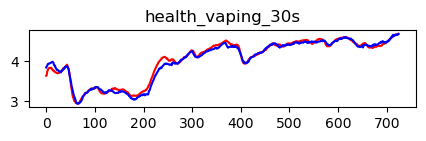

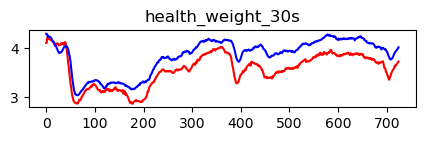

In [49]:
x_length = 725

total_recall_means = np.zeros((n_spots, 2))

for current_spot_index in range(n_spots):
    current_spot = spot_list[current_spot_index]
    #print(current_spot)

    
    recalled_pupil_data = []
    not_recalled_pupil_data = []

    for current_condition_index in range(3): # 0  # 0, 1, 2

        current_condition = condition_list[current_condition_index]
        curr_search_folder = '../data/03_spots_memory_data/' + current_spot + '/' + current_condition + '/' 
        #print(curr_search_folder)

        # read recalled data
        recalled = glob.glob(os.path.join(curr_search_folder, '*recall1.csv'))
        #n_recall = len(recalled)

        for curr_file in recalled:
            curr_data =     pd.read_csv(curr_file)['pupil diameter']
            curr_data_int = curr_data.interpolate().values[:x_length]
            recalled_pupil_data.append((curr_data_int)) #zscore
        
        # read non-recalled data
        not_recalled = glob.glob(os.path.join(curr_search_folder, '*recall0.csv'))
        #n_notrecall = len(recalled)


        for curr_file in not_recalled:
            curr_data =     pd.read_csv(curr_file)['pupil diameter']
            curr_data_int = curr_data.interpolate(method = 'slinear').values[:x_length]
            not_recalled_pupil_data.append((curr_data_int)) #zscore
            
            if len(curr_data_int) < x_length:
                print('problem !!! ')
                print(curr_file)
        


    recalled_pupil_data = np.asarray(recalled_pupil_data)
    #print(recalled_pupil_data.shape)
    
    not_recalled_pupil_data = np.asarray(not_recalled_pupil_data)
    #print(not_recalled_pupil_data.shape)

    '''plt.figure(figsize = (10,2))
    plt.plot(recalled_pupil_data.T, color = 'red');
    plt.plot(not_recalled_pupil_data.T, color = 'blue');
    plt.title(current_spot)#'''

    plt.figure(figsize = (5,1))
    plt.plot(np.nanmean(recalled_pupil_data, axis =0).T, color = 'red');
    plt.plot(np.nanmean(not_recalled_pupil_data, axis = 0).T, color = 'blue');
    plt.title(current_spot)
    
    total_recall_means[current_spot_index, 0] = np.nanmean(recalled_pupil_data[:,250:])
    total_recall_means[current_spot_index, 1] = np.nanmean(not_recalled_pupil_data[:,250:])

    

    

In [50]:
print(not_recalled_pupil_data.shape)
print(recalled_pupil_data.shape)

(41, 725)
(17, 725)


In [52]:
total_recall_means

array([[3.64887862, 3.54677974],
       [4.39748684, 4.39090247],
       [4.08526561, 3.96842133],
       [4.01872982, 3.94260874],
       [3.81653923, 3.97686518],
       [3.96192193, 3.955865  ],
       [4.12378816, 4.06499985],
       [3.97044795, 3.90762527],
       [4.46419433, 4.29203234],
       [4.26615956, 4.04501704],
       [4.04090526, 4.02695679],
       [3.99974737, 3.89024342],
       [4.00821009, 4.10612466],
       [4.6209912 , 4.48259604],
       [4.17270863, 4.2215395 ],
       [3.6493247 , 4.01448308],
       [4.19673918, 4.27669459],
       [4.18264085, 4.33538139],
       [4.05186133, 4.06929542],
       [3.71286614, 3.84627935],
       [4.17833041, 4.45880635],
       [4.1031185 , 4.19141969],
       [4.22297285, 4.19838791],
       [3.49959762, 3.63306894],
       [3.50463772, 3.58808738],
       [4.01260674, 4.34542135],
       [3.99105654, 4.19237155],
       [4.03001504, 3.89603743],
       [4.35165545, 4.33697951],
       [3.70842786, 4.03891626]])

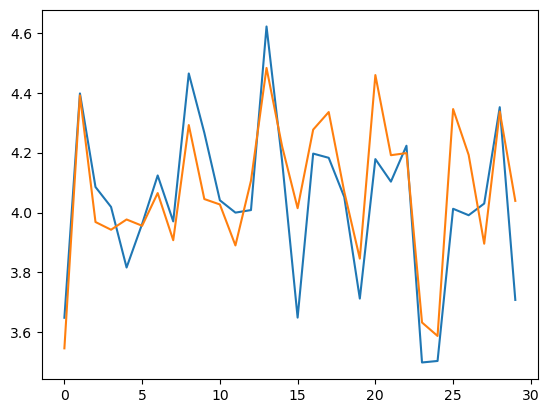

In [53]:
plt.plot(total_recall_means);

In [54]:
total_recall_means[:,0] 

array([3.64887862, 4.39748684, 4.08526561, 4.01872982, 3.81653923,
       3.96192193, 4.12378816, 3.97044795, 4.46419433, 4.26615956,
       4.04090526, 3.99974737, 4.00821009, 4.6209912 , 4.17270863,
       3.6493247 , 4.19673918, 4.18264085, 4.05186133, 3.71286614,
       4.17833041, 4.1031185 , 4.22297285, 3.49959762, 3.50463772,
       4.01260674, 3.99105654, 4.03001504, 4.35165545, 3.70842786])

In [55]:
total_recall_means[:,1] 

array([3.54677974, 4.39090247, 3.96842133, 3.94260874, 3.97686518,
       3.955865  , 4.06499985, 3.90762527, 4.29203234, 4.04501704,
       4.02695679, 3.89024342, 4.10612466, 4.48259604, 4.2215395 ,
       4.01448308, 4.27669459, 4.33538139, 4.06929542, 3.84627935,
       4.45880635, 4.19141969, 4.19838791, 3.63306894, 3.58808738,
       4.34542135, 4.19237155, 3.89603743, 4.33697951, 4.03891626])

In [56]:
from scipy.stats import ttest_1samp
ttest_1samp(total_recall_means[:,0] - total_recall_means[:,1], 0)

TtestResult(statistic=-1.4621656353215429, pvalue=0.1544490713881053, df=29)

In [ ]:
print(~np.isnan(data).any(axis=1))

print(data.shape)
new_data = data[~np.isnan(data).any(axis=1), :]
new_data.shape
#not_recalled_pupil_data

[ True  True  True  True  True  True  True False False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True  True  True False
  True  True  True  True  True]
(41, 725)


(37, 725)

In [60]:
for i in range(11):
        print(not_recalled_pupil_data[i].shape)

(725,)
(725,)
(725,)
(725,)
(725,)
(725,)
(725,)
(725,)
(725,)
(725,)
(725,)


In [61]:
data = not_recalled_pupil_data
data.shape

(41, 725)

In [63]:
from scipy.spatial.distance import squareform

pupil_isc(data.T)

Assuming 41 subjects with 725 time points and 1 voxel(s) or ROI(s).


array([[nan]])

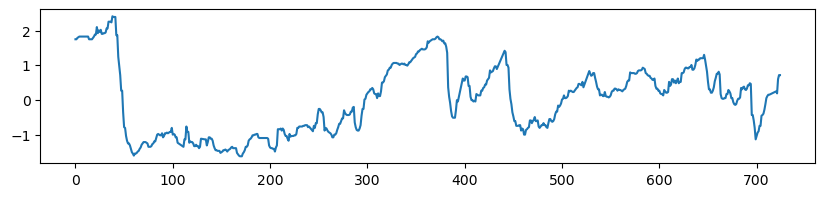

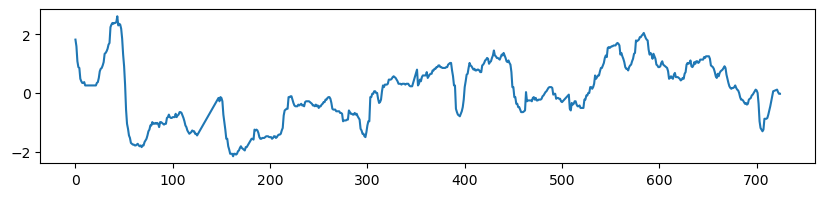

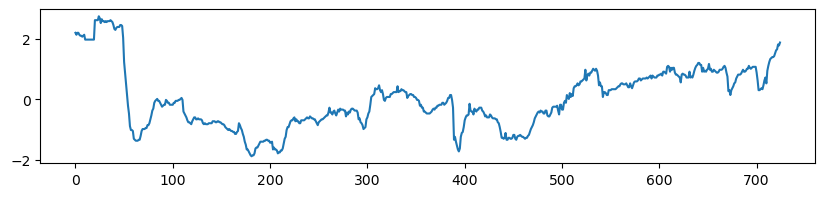

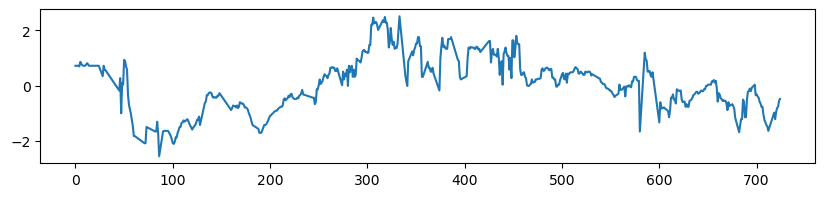

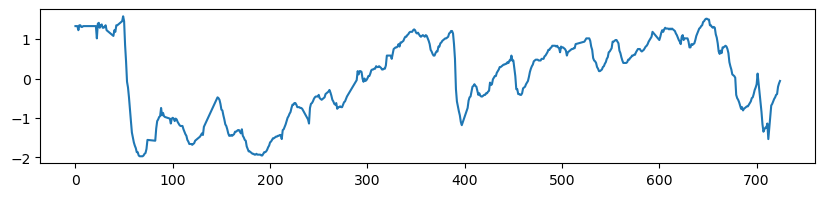

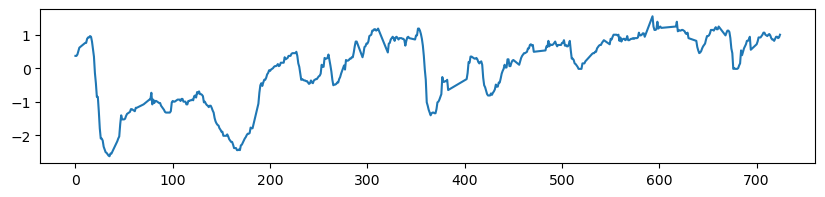

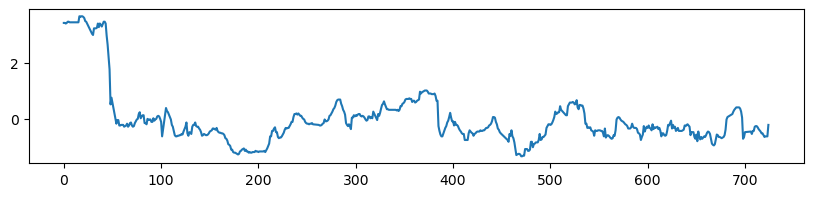

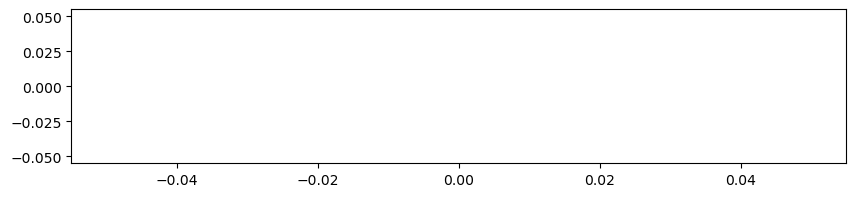

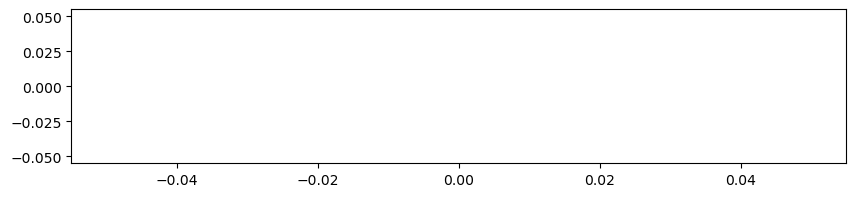

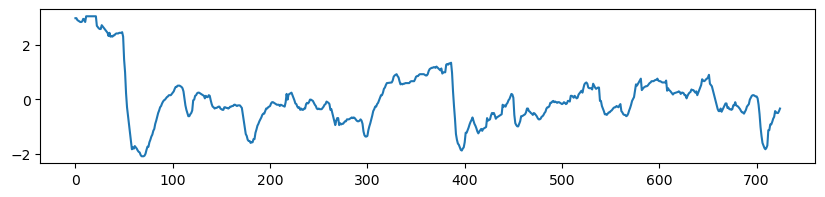

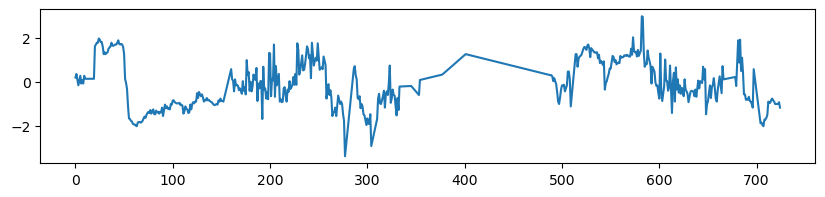

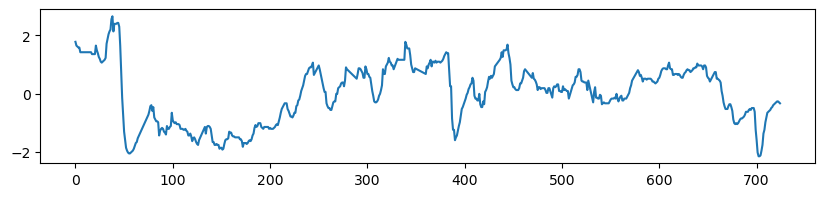

In [29]:
for i in range(12):
    plt.figure(figsize = (10,2))
    plt.plot(data[i,:])
    

True

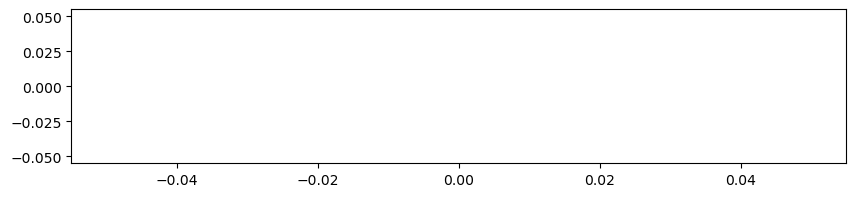

In [30]:
i =7
plt.figure(figsize = (10,2))
plt.plot(data[i,:])

np.isnan(data[i,:]).all()
